In [7]:
#pip install opencv-python
#pip install dlib

In [9]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
import re



In [10]:
#This is a test cell. Ideally this would be turned into a function
Photo = cv2.imread('Potential datasets/lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg', 0)
#Photo = cv2.medianBlur(Photo, 5)
NULL, threshold1 = cv2.threshold(Photo, 127, 255, cv2.THRESH_BINARY)
threshold2 = cv2.adaptiveThreshold(Photo, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                            cv2.THRESH_BINARY, 11, 2)
threshold3 = cv2.adaptiveThreshold(Photo, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY, 11, 2)


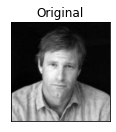

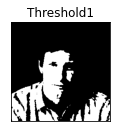

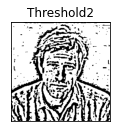

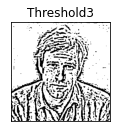

In [11]:
#image we are modifying
plt.subplot(2, 2, 1), plt.imshow(Photo, 'gray')
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.show()
#Regular treshold
plt.subplot(2, 2, 2), plt.imshow(threshold1, 'gray')
plt.title('Threshold1')
plt.xticks([]), plt.yticks([])
plt.show()
#Mean Thresholding
plt.subplot(2, 2, 3), plt.imshow(threshold2, 'gray')
plt.title('Threshold2')
plt.xticks([]), plt.yticks([])
plt.show()
#Gaussian Threshold
plt.subplot(2, 2, 4), plt.imshow(threshold3, 'gray')
plt.title('Threshold3')
plt.xticks([]), plt.yticks([])
plt.show()


In [12]:
from PIL import Image

photosDirectory = []

#First we load all of our files. 
directory = 'SmallerDataSet(cleaned)/'
for file2 in os.listdir(directory):
    path = directory + file2 

    pathForTemp = "TempFiles/" + file2
    try:
        os.makedirs(pathForTemp)
    except:
        VOID = "do nothing :)"
        #This is just to skip the file already exists error
    for FilepathPhotos in os.listdir(path):
        pathForPhoto = path + "/" + FilepathPhotos
        photosDirectory.append(pathForPhoto)
        #Dont run this code it opens every single image. (Good to see what images are being used)
        #image = Image.open(pathForPhoto) 
        #image.show()
#photosDirectory stores the file path for each image we are gonna use
#photosDirectory

In [43]:
#Now we make a function that finds the faces of each picture

FaceDat = cv2.CascadeClassifier("TrainingData/haarcascade_frontalface_default.xml")
def faceDetect(path, newDir):
    Photo = cv2.imread(path)
    grysc = cv2.cvtColor(Photo, cv2.COLOR_BGR2GRAY)
    faceDetected = FaceDat.detectMultiScale(grysc, 1.1, 4)
    for(x, y, w, h) in faceDetected:
        cv2.rectangle(Photo, (x,y), (x+w, y+h), (255, 0, 0), 2)
    cv2.imwrite(newDir, Photo, [cv2.IMWRITE_JPEG_QUALITY, 100])
    


In [44]:
#This recursively draws a rectangle around all of the faces we are reading.
for photos in photosDirectory:
    newDir = photos.replace("SmallerDataSet(cleaned)", "TempFiles")
    faceDetect(photos, newDir)
